Constructing SVM model
Grabbing user data
Calculating science sentiment scores


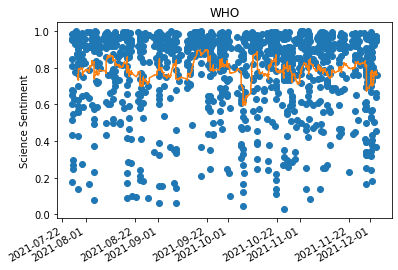

In [2]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV
import subprocess
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def Twitter_TL(user):
    user = input("Enter Twitter handle: ")
    filename = user + '.jsonl'
    op1 = open(filename, 'w')
    subprocess.call(['twarc', 'timeline', user], stdout=op1)

#Takes single Tweet as string

def Twitter_Science_Sentiment(user):
    print('Constructing SVM model')
    #Loading Dataframes
    pro_sci = pd.read_csv('pro_science.csv',sep=',')
    anti_sci = pd.read_csv('anti_science.csv')

    #Renaming and Cleaning Dataframes
    pro_sci = pro_sci.drop(columns='Unnamed: 0')
    pro_sci.rename(columns= {'0':'Tweet'}, inplace=True)
    #adds label 0 for pro-science Tweets
    pro_sci['label'] = 1

    anti_sci = anti_sci.drop(columns='Unnamed: 0')
    anti_sci.rename(columns= {'0':'Tweet'}, inplace=True)
    #adds label 0 for anti-science Tweets
    anti_sci['label'] = 0

    corpus = pro_sci.append(anti_sci, ignore_index=True)

    #Text processing in corpus dataframe
    #Lowercase
    corpus['Tweet'] = [entry.lower() for entry in corpus['Tweet']]
    #Tokenizing
    corpus['Tweet']= [word_tokenize(entry) for entry in corpus['Tweet']]
    #Tags for Word Lemmatization
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV

    for index,entry in enumerate(corpus['Tweet']):
        final_words = []
        # Initializing WordNetLemmatizer()
        word_Lemmatized = WordNetLemmatizer()
        # Provides tags for nouns, verbs, adjectives
        for word, tag in pos_tag(entry):
            # Check for stopwords
            if word not in stopwords.words('english') and word.isalpha():
                word_final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                final_words.append(word_final)
        # Stores final processed words for each Tweet in column "text_final"
        corpus.loc[index,'text_final'] = str(final_words)
    Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(corpus['text_final'],corpus['label'],test_size=0.05)
    Tfidf_vect = TfidfVectorizer(ngram_range=(1,3))
    Tfidf_vect.fit(corpus['text_final'])

    Train_X_Tfidf = Tfidf_vect.transform(Train_X)
    Test_X_Tfidf = Tfidf_vect.transform(Test_X)

    #Support Vector Machine

    svm_clf = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', probability=True)
    clf = CalibratedClassifierCV(base_estimator=svm_clf) 
    clf.fit(Train_X_Tfidf,Train_Y, np.random.seed(42))
    svm_pred = clf.predict(Test_X_Tfidf)
    #print("SVM Accuracy Score -> ",accuracy_score(svm_pred, Test_Y))

    def sci_sentiment(tweet):
        df = pd.DataFrame([tweet],columns=['Tweet'])
        df['Tweet'] = [entry.lower() for entry in df['Tweet']]
        Tfidf_vect.fit(corpus['text_final'])
        tweet_Tfidf = Tfidf_vect.transform((df['Tweet']))
        svm_tweet_pred = clf.predict(tweet_Tfidf)
        #print('SVM:', svm_tweet_pred)
        pred_probs = clf.predict_proba(tweet_Tfidf)
        return pred_probs[0][1]

    print('Grabbing user data')
    Twitter_TL(user)
    filename = user + '.jsonl'

    import jsonlines
    date_list = []
    dt_date_list = []
    text_list = []
    word_set = set(['COVID-19','covid','vaccine','flu','sick','mask','jab','CDC','corona','coronavirus','virus','covid19', 'spread','pandemic','outbreak','transmission','symptom','asymptomatic','social distance','social distancing','quarantine','lockdown','shot','healthy','medical','science','health'])
    with jsonlines.open(filename) as f:
        for line in f.iter():
            if word_set.intersection(set(line['full_text'].split())):
                date_list.append(line['created_at'])
                text_list.append(line['full_text'])
    for i in date_list:
        dt_date_list.append(datetime.strftime(datetime.strptime(i,'%a %b %d %H:%M:%S +0000 %Y'), '%Y-%m-%d %H:%M:%S'))
    user_df = pd.DataFrame([dt_date_list, text_list], index = ['created_at','text']).transpose().iloc[::-1]
    #print(user_df)
    print('Calculating science sentiment scores')
    sci_sentiment_scores = []
    for tweet in user_df['text']:
        sci_sentiment_scores.append(sci_sentiment(tweet))

    user_df['sci_score'] = sci_sentiment_scores
    fdates = []
    dateformat = '%Y-%m-%d %H:%M:%S'
    for dt in user_df['created_at']:
        fdates.append(datetime.strptime(dt,dateformat))
    datesfinal = mdates.date2num(fdates)

    user_df['SMA'] = user_df.sci_score.rolling(((round(.03*len(user_df.index))))).mean()
    
    plt.plot_date(datesfinal,user_df['sci_score'])
    plt.plot_date(datesfinal,user_df['SMA'],linestyle='solid',marker=",")
    plt.xlabel
    plt.title(user)
    plt.gcf().autofmt_xdate()
    plt.ylabel('Science Sentiment')
    return plt.show(block=True)

Twitter_Science_Sentiment('WHO')